In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from gensim.models import KeyedVectors
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

import sys
from pathlib import Path

# Add the project root directory to Python path
project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import load_models

import matplotlib.pyplot as plt
# 设置更好的可视化风格

# 设置更好的可视化风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
# 假设notebooks目录在项目根目录下


from src.utils import download_chinese_font
import src.utils as utils
# 下载并安装字体
font_path = download_chinese_font()

# 设置matplotlib使用下载的字体
if font_path:
    plt.rcParams['font.sans-serif'] = ['SimHei'] + plt.rcParams['font.sans-serif']
    print("成功设置中文字体")
else:
    print("无法设置中文字体，将使用替代方案")

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


# 定义项目根目录和模型目录
PROJECT_ROOT = Path.cwd().parent
MODELS_DIR = PROJECT_ROOT / "models"

# 可能的模型目录
FINE_TUNED_MODELS_DIR = MODELS_DIR / "fine_tuned_vectors_flexible"
SLIDING_WINDOW_MODELS_DIR = MODELS_DIR / "fine_tuned_vectors_sliding_window"

models = load_models(MODELS_DIR)

字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体
使用固定时期模型目录: /home/fangshikai/law-word-vector/models/fine_tuned_vectors_flexible
找到 3 个模型文件:
  加载模型: Era1_1978-1996
  成功加载 Era1_1978-1996, 词汇量: 4874
  加载模型: Era2_1997-2013
  成功加载 Era2_1997-2013, 词汇量: 4992
  加载模型: Era3_2014-2024
  成功加载 Era3_2014-2024, 词汇量: 5000


In [2]:
# 创建输出目录
topic_word_dir = Path("topic_word")
topic_word_dir.mkdir(exist_ok=True)

In [3]:

# 2. 加载相似词数据
era_files = {
    'Era1_1978-1996': 'similar_words/Era1_1978-1996_final.txt',
    'Era2_1997-2013': 'similar_words/Era2_1997-2013_final.txt',
    'Era3_2014-2024': 'similar_words/Era3_2014-2024_final.txt'
}

similar_words_by_period = {}
for era, file_path in era_files.items():
    word_list = utils.load_expert_word_list(file_path)
    if word_list:
        similar_words_by_period[era] = word_list
        print(f"加载 {era}: {len(word_list)} 个词")

加载 Era1_1978-1996: 150 个词
加载 Era2_1997-2013: 150 个词
加载 Era3_2014-2024: 150 个词


In [12]:
from dimension_clustering import cluster_similar_words, visualize_clusters, save_cluster_results,analyze_cluster_quality



=== 执行4聚类分析 ===
已加载 17 个排除词
Era1_1978-1996: 过滤后保留 149 个词
Era2_1997-2013: 过滤后保留 148 个词
Era3_2014-2024: 过滤后保留 148 个词
所有时期共有词: 41 个
所有时期词汇并集: 284 个
聚类分析使用词汇数量: 284
使用 Era3_2014-2024 模型进行聚类
有效词汇数量: 233
聚类1: 43 个词
  前10个词: ['法律条文', '法律意识', '普法教育', '教育引导', '自觉遵守', '法制宣传', '解决矛盾', '人治', '法治思维', '法治理念']
聚类2: 45 个词
  前10个词: ['政治文明', '善治', '社会主义法治国家', '政治体制改革', '经济体制', '法典', '组织法', '民族事务', '治理能力', '依法治国']
聚类3: 113 个词
  前10个词: ['惩治', '违法行为', '社会秩序', '规则', '产权保护', '惩戒', '司法机关', '尊严', '保障体系', '诚信']
聚类4: 32 个词
  前10个词: ['程序正义', '民告官', '公信', '执法不严', '执法必严', '违法不究', '公正司法', '执法为民', '司法公正', '惩恶扬善']


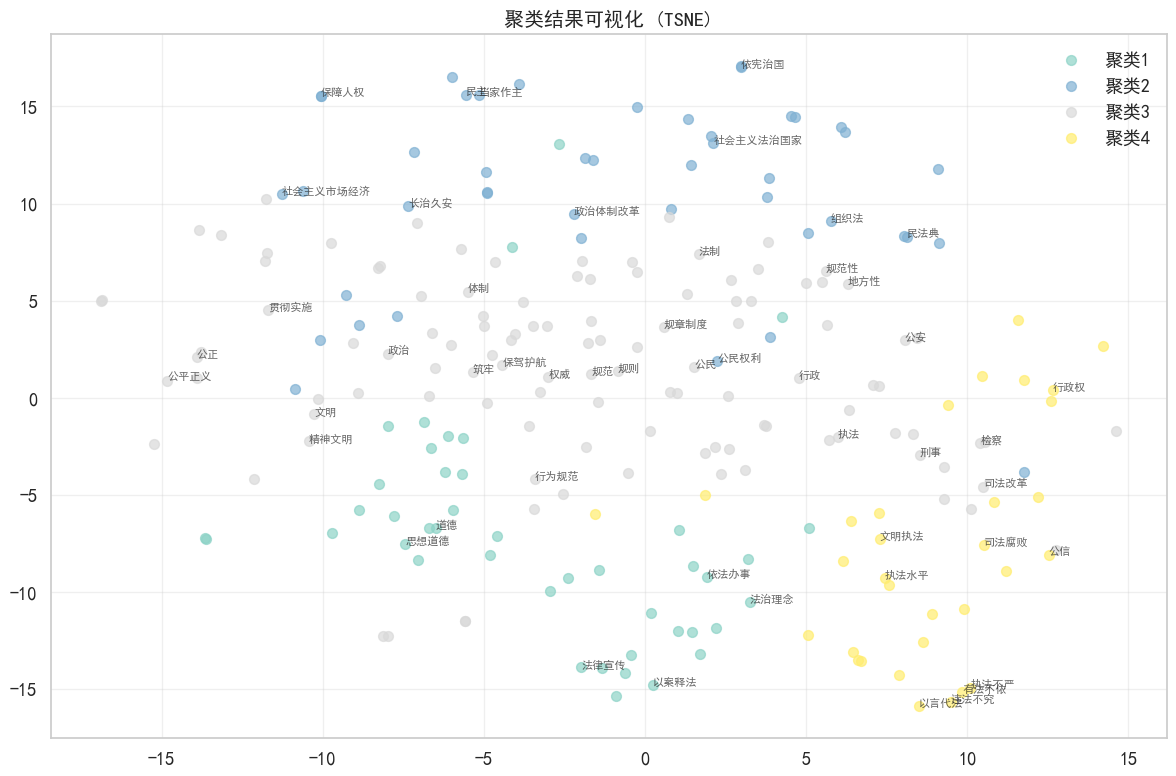

已保存聚类结果到: topic_word/cluster_results_4.txt
轮廓系数 (Silhouette Score): 0.052
Calinski-Harabasz指数: 11.085


(0.052169308, 11.085016242087953)

In [13]:
# 3. 执行4聚类分析
print("\n=== 执行4聚类分析 ===")
clusters_4, word_vectors_4, cluster_labels_4, valid_words_4 = cluster_similar_words(
    models, similar_words_by_period, n_clusters=4, 
    exclude_words_path="exclude_words.txt", top_n=150
)
# 可视化
visualize_clusters(word_vectors_4, cluster_labels_4, valid_words_4, method='tsne')

# 保存聚类结果
save_cluster_results(clusters_4, topic_word_dir / "cluster_results_4.txt")

# 分析聚类质量
analyze_cluster_quality(word_vectors_4, cluster_labels_4)


# print("\n=== 执行3聚类分析 ===")
# all_results_cluster_3= cluster_similar_words(
#     models, similar_words_by_period, n_clusters=3, 
#     exclude_words_path="exclude_words.txt", top_n=150
# )

In [29]:
def calculate_dimension_similarities(models, dimension_words, target_word="法治", normalize=False):
    """
    计算目标词与各维度的相似度
    
    Args:
        models: 词向量模型字典
        dimension_words: 维度词表字典
        target_word: 目标词
        normalize: 是否归一化 (默认False, 确保每个period的各个维度的相似度总和为1)
        
    Returns:
        DataFrame: 各时期各维度的相似度矩阵
    """
    periods = sorted(models.keys())
    dimensions = list(dimension_words.keys())
    
    # 创建结果DataFrame
    similarity_data = []
    
    for period in periods:
        model = models[period]
        if target_word not in model:
            print(f"警告: '{target_word}'在{period}模型中不存在")
            continue
            
        period_similarities = {"时期": period}
        
        for dim in dimensions:
            dim_words = dimension_words[dim]
            similarities = []
            
            for word in dim_words:
                if word in model and word != target_word:
                    try:
                        sim = model.similarity(target_word, word)
                        similarities.append(sim)
                    except:
                        pass
            
            if similarities:
                avg_sim = np.mean(similarities)
                period_similarities[dim] = avg_sim
            else:
                period_similarities[dim] = 0
        
        if normalize:
            sum_sim = sum(period_similarities[dim] for dim in dimensions)
            period_similarities = {dim: period_similarities[dim] / sum_sim for dim in dimensions}
            
        similarity_data.append(period_similarities)
    
    return pd.DataFrame(similarity_data),period_similarities


已加载4维度词表:
  制度建构: 21 个词
  程序正义: 18 个词
  权利保障: 20 个词
  治理效能: 20 个词

4维度相似度矩阵:
               时期      制度建构      程序正义      权利保障      治理效能
0  Era1_1978-1996  0.309728  0.264290  0.207684  0.365729
1  Era2_1997-2013  0.357989  0.382325  0.310768  0.501166
2  Era3_2014-2024  0.360454  0.280954  0.285411  0.449224


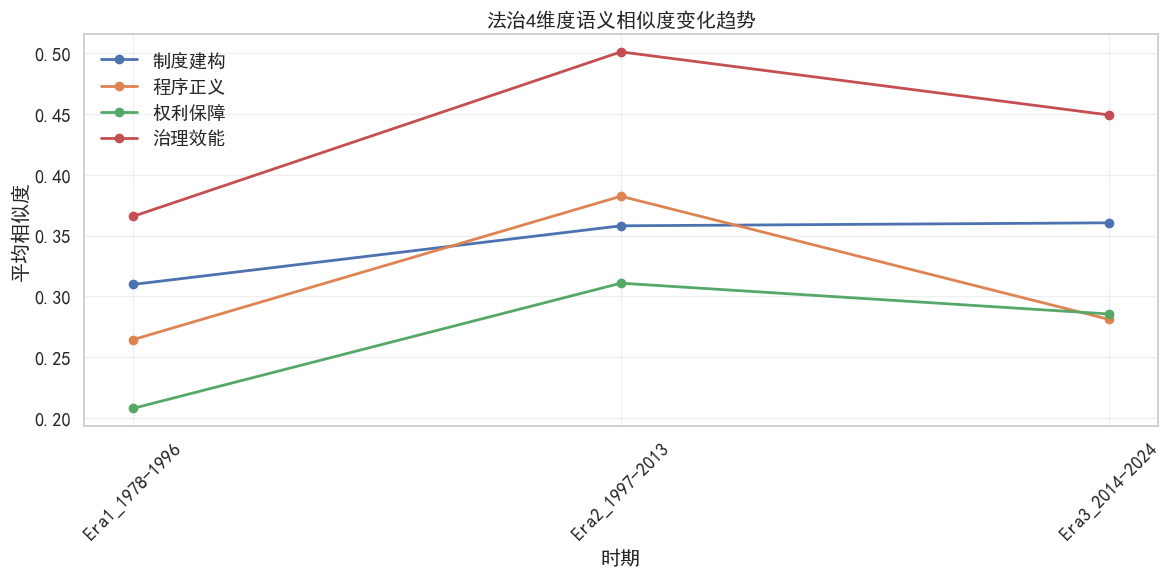

<Figure size 640x480 with 0 Axes>

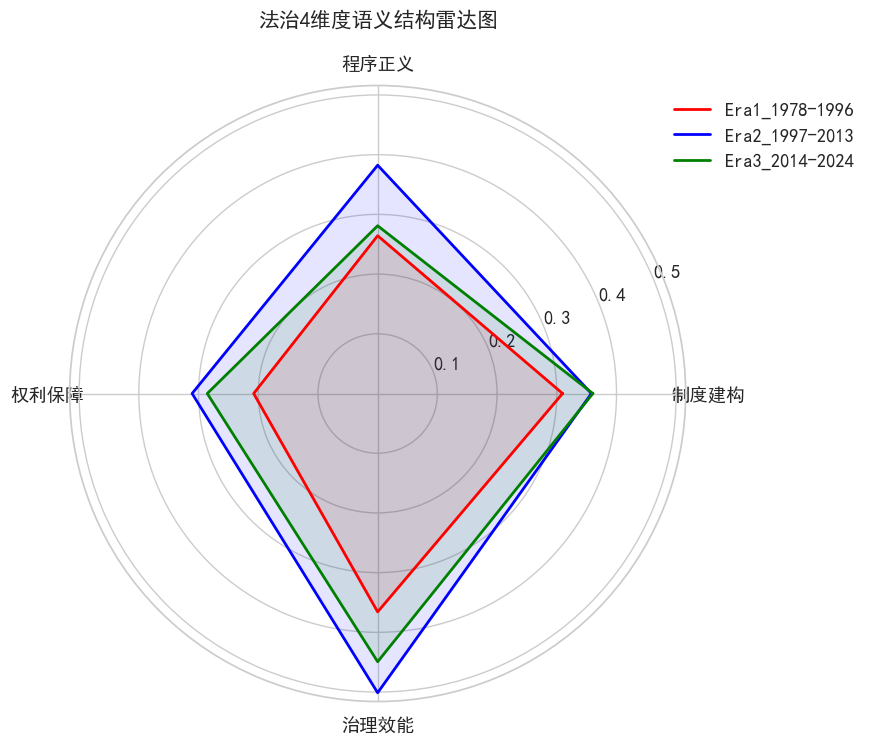

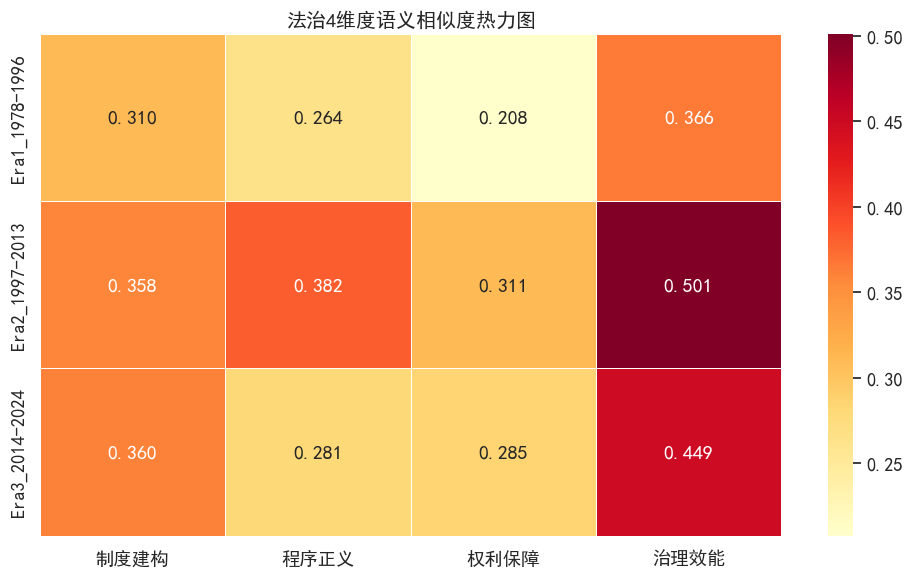

<Figure size 640x480 with 0 Axes>

In [18]:
from dimension_analysis import load_dimension_words, calculate_dimension_similarities, plot_dimension_trends, plot_dimension_radar, plot_dimension_heatmap

dimension_words_4d = load_dimension_words(topic_word_dir / "dimension_words_4d.txt")
if dimension_words_4d:
    print("\n已加载4维度词表:")
    for dim, words in dimension_words_4d.items():
        print(f"  {dim}: {len(words)} 个词")
    
    # 计算相似度
    similarity_df_4d = calculate_dimension_similarities(
        models, 
        dimension_words_4d,
        target_word="法治",
        # normalize=True
        )
    print("\n4维度相似度矩阵:")
    print(similarity_df_4d)
    
    # 绘制可视化
    if not similarity_df_4d.empty:
        plot_dimension_trends(similarity_df_4d, "法治4维度语义相似度变化趋势")
        plot_dimension_radar(similarity_df_4d, "法治4维度语义结构雷达图")
        plot_dimension_heatmap(similarity_df_4d, "法治4维度语义相似度热力图")



=== 基于平均相似度扩展4维度词表 ===
使用所有 3 个模型的平均相似度进行词表扩展
候选词数量: 1146

扩展后的词表统计:
制度建构: 80 个词 (原有 21 + 新增 59)
程序正义: 80 个词 (原有 18 + 新增 62)
权利保障: 71 个词 (原有 20 + 新增 51)
治理效能: 80 个词 (原有 20 + 新增 60)
已保存扩展词表到: expanded_dimension_words_4d.txt

4维度相似度矩阵:
               时期      制度建构      程序正义      权利保障      治理效能
0  Era1_1978-1996  0.269932  0.230332  0.180999  0.318738
1  Era2_1997-2013  0.230626  0.246304  0.200205  0.322865
2  Era3_2014-2024  0.261950  0.204175  0.207414  0.326461

=== 扩展后词表相似度分析 ===

扩展后4维度相似度矩阵:
               时期      制度建构      程序正义      权利保障      治理效能
0  Era1_1978-1996  0.263733  0.254010  0.212522  0.269735
1  Era2_1997-2013  0.231653  0.248102  0.233302  0.286943
2  Era3_2014-2024  0.257287  0.238991  0.223543  0.280179


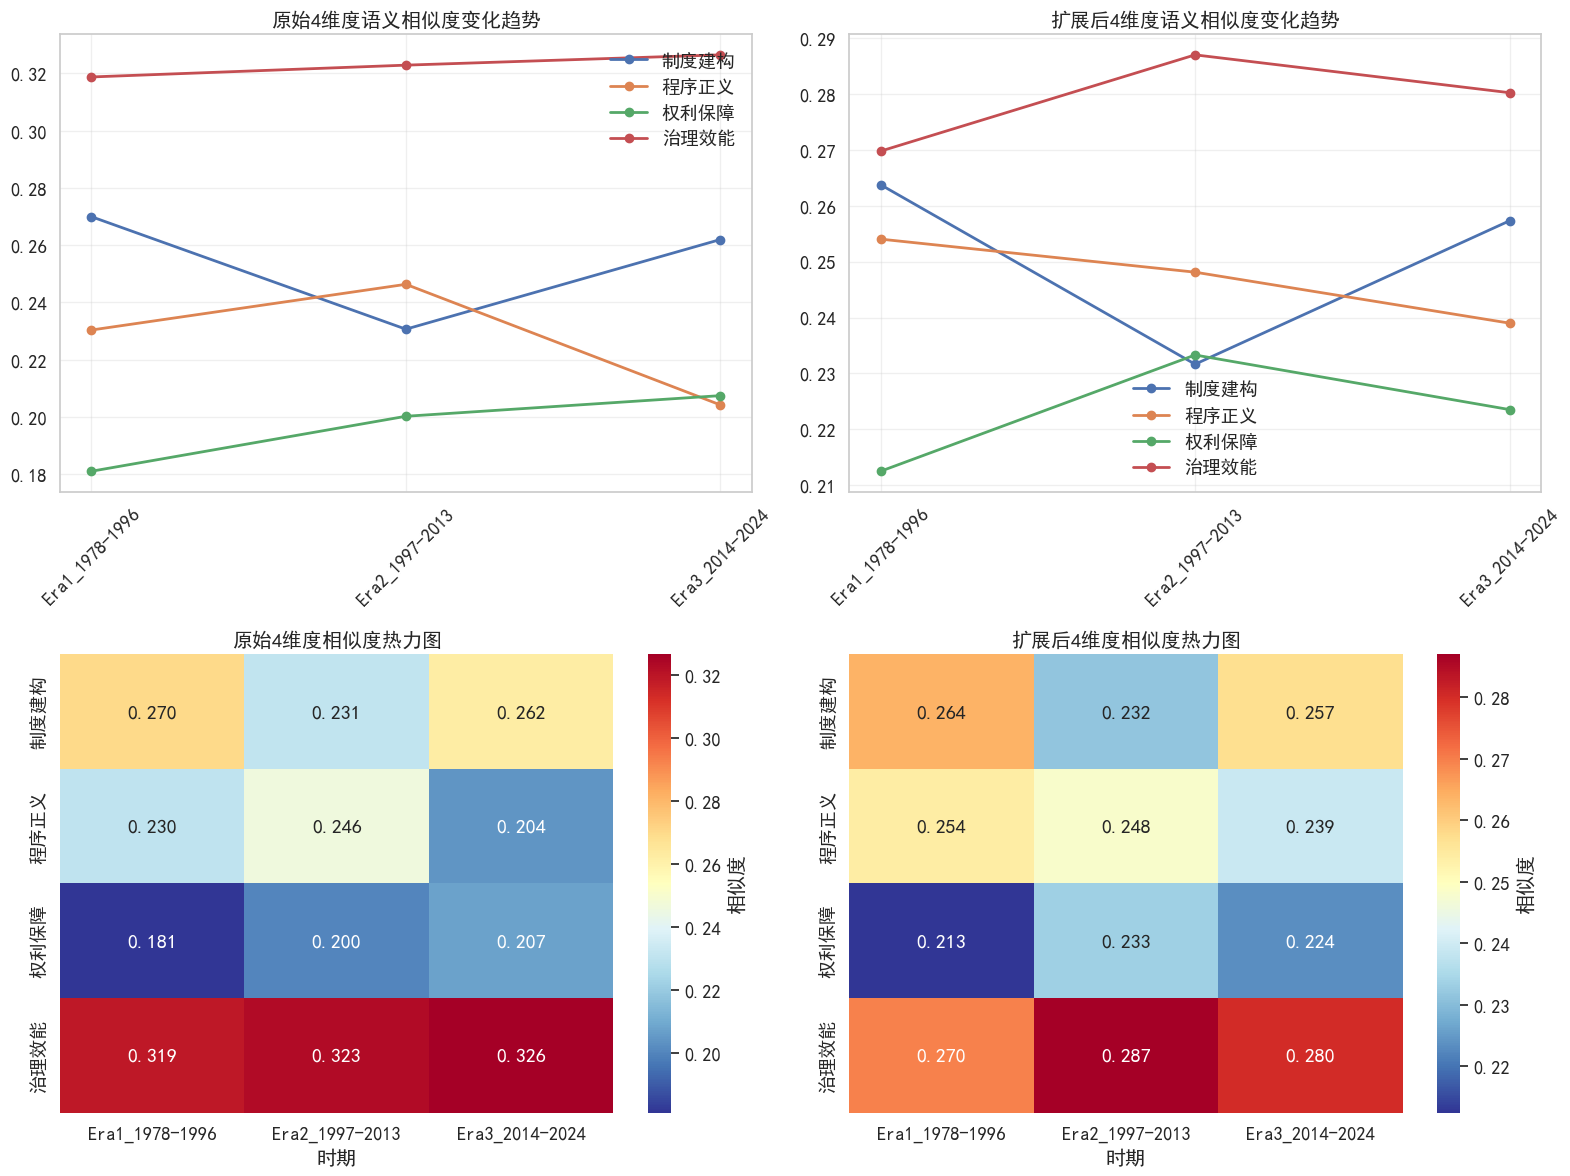


=== 各维度新增词汇示例 ===

制度建构 新增词汇 (59个):
  示例: 乡规民约, 规则, 社会公众, 公职人员, 规章制度, 法等, 建立健全, 规制, 法制化, 完备, 职责, 由此可见, 法学, 做法, 检察工作, 三是, 全国人大常委会法工委, 进一步, 有章可循, 宣传教育

程序正义 新增词汇 (62个):
  示例: 执法不严, 司法权, 严格执行, 二要, 普治, 重典, 根本大法, 卓泽渊, 依法处理, 法律化, 国法, 监督制约, 功过, 凡属, 刘武俊, 依法办案, 徐显明, 法家, 法律监督, 人权意识

权利保障 新增词汇 (51个):
  示例: 应有, 尊重人权, 践踏, 切实, 捍卫, 而言, 尊严, 行使, 公理, 权益, 本位, 正义, 安居乐业, 主体, 民事权利, 公正, 事实证明, 保障, 保障人权, 其本质

治理效能 新增词汇 (60个):
  示例: 体系化, 和谐社会, 整饬, 推进改革, 自律, 明察, 重要环节, 付子堂, 长治久安, 从己, 港治澳, 判断是非, 政法队伍, 严格执法, 立而, 公信, 治, 行为习惯, 遇事, 相得益彰


In [21]:

def expand_dimension_words_by_similarity(models, dimension_words, target_word="法治", 
                                       similarity_threshold=0.3, max_words_per_dim=50):
    """
    基于词向量相似度扩展维度词表（使用所有模型的平均相似度）
    
    Args:
        models: 词向量模型字典
        dimension_words: 初始维度词表
        target_word: 目标词（法治）
        similarity_threshold: 相似度阈值
        max_words_per_dim: 每个维度最大词数
        
    Returns:
        dict: 扩展后的维度词表
    """
    expanded_words = {dim: set(words) for dim, words in dimension_words.items()}
    
    print(f"使用所有 {len(models)} 个模型的平均相似度进行词表扩展")
    
    # 收集所有时期中与目标词相似的候选词
    candidate_words = set()
    
    for period, model in models.items():
        if target_word in model:
            similar_words = model.most_similar(target_word, topn=500)
            for word, similarity in similar_words:
                if similarity >= similarity_threshold:
                    candidate_words.add(word)
    
    print(f"候选词数量: {len(candidate_words)}")
    
    # 为每个候选词计算跨时期的平均相似度
    for word in candidate_words:
        # 计算与目标词的平均相似度
        target_similarities = []
        for period, model in models.items():
            if target_word in model and word in model:
                try:
                    sim = model.similarity(target_word, word)
                    target_similarities.append(sim)
                except:
                    pass
        
        if not target_similarities or np.mean(target_similarities) < similarity_threshold:
            continue
            
        # 计算该词与各维度核心词的平均相似度
        dim_similarities = {}
        
        for dim, core_words in dimension_words.items():
            all_dim_similarities = []
            
            for core_word in core_words:
                period_similarities = []
                for period, model in models.items():
                    if core_word in model and word in model:
                        try:
                            sim = model.similarity(word, core_word)
                            period_similarities.append(sim)
                        except:
                            pass
                
                if period_similarities:
                    all_dim_similarities.append(np.mean(period_similarities))
            
            if all_dim_similarities:
                dim_similarities[dim] = np.mean(all_dim_similarities)
        
        # 将词分配给相似度最高的维度
        if dim_similarities:
            best_dim = max(dim_similarities, key=dim_similarities.get)
            if (dim_similarities[best_dim] > similarity_threshold and 
                len(expanded_words[best_dim]) < max_words_per_dim):
                expanded_words[best_dim].add(word)
    
    # 转换回列表格式
    result = {dim: list(words) for dim, words in expanded_words.items()}
    
    print("\n扩展后的词表统计:")
    for dim, words in result.items():
        original_count = len(dimension_words[dim])
        expanded_count = len(words)
        new_words_count = expanded_count - original_count
        print(f"{dim}: {expanded_count} 个词 (原有 {original_count} + 新增 {new_words_count})")
    
    return result



# 运行词表扩展
print("\n=== 基于平均相似度扩展4维度词表 ===")
expanded_dimension_words_4d = expand_dimension_words_by_similarity(
    models, dimension_words_4d, target_word="法治", 
    similarity_threshold=0.25, max_words_per_dim=80
)

# 保存扩展后的词表
def save_expanded_dimension_words(expanded_words, output_path):
    """保存扩展后的维度词表"""
    output_path = Path(output_path)
    output_path.parent.mkdir(exist_ok=True)
    
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write("# 扩展后的法治4维度词表\n\n")
        
        for dim, words in expanded_words.items():
            f.write(f"# {dim} ({len(words)}个词)\n")
            f.write(f"{dim}:\n")
            
            # 每行写10个词
            for i in range(0, len(words), 10):
                line_words = words[i:i+10]
                f.write(" ".join(line_words) + "\n")
            f.write("\n")
    
    print(f"已保存扩展词表到: {output_path}")

# 保存扩展后的词表
save_expanded_dimension_words(expanded_dimension_words_4d, "expanded_dimension_words_4d.txt")

similarity_df_4d = calculate_dimension_similarities(
    models, dimension_words_4d,target_word="法治",normalize=True)
print("\n4维度相似度矩阵:")
print(similarity_df_4d)

# 计算扩展后词表的相似度并可视化
print("\n=== 扩展后词表相似度分析 ===")
expanded_similarity_df_4d = calculate_dimension_similarities(
    models, expanded_dimension_words_4d, target_word="法治", normalize=True
)

print("\n扩展后4维度相似度矩阵:")
print(expanded_similarity_df_4d)

# 对比原始和扩展后的相似度
if not expanded_similarity_df_4d.empty:
    # 绘制对比图
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 原始词表趋势图
    axes[0, 0].set_title("原始4维度语义相似度变化趋势")
    for dim in similarity_df_4d.columns[1:]:
        axes[0, 0].plot(similarity_df_4d['时期'], similarity_df_4d[dim], 
                       marker='o', linewidth=2, label=dim)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 扩展后词表趋势图
    axes[0, 1].set_title("扩展后4维度语义相似度变化趋势")
    for dim in expanded_similarity_df_4d.columns[1:]:
        axes[0, 1].plot(expanded_similarity_df_4d['时期'], expanded_similarity_df_4d[dim], 
                       marker='o', linewidth=2, label=dim)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 原始词表热力图
    original_heatmap_data = similarity_df_4d.set_index('时期').T
    sns.heatmap(original_heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                ax=axes[1, 0], cbar_kws={'label': '相似度'})
    axes[1, 0].set_title("原始4维度相似度热力图")
    
    # 扩展后词表热力图
    expanded_heatmap_data = expanded_similarity_df_4d.set_index('时期').T
    sns.heatmap(expanded_heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                ax=axes[1, 1], cbar_kws={'label': '相似度'})
    axes[1, 1].set_title("扩展后4维度相似度热力图")
    
    plt.tight_layout()
    plt.show()
    
    # 显示新增词汇示例
    print("\n=== 各维度新增词汇示例 ===")
    for dim in dimension_words_4d.keys():
        original_words = set(dimension_words_4d[dim])
        expanded_words = set(expanded_dimension_words_4d[dim])
        new_words = expanded_words - original_words
        
        print(f"\n{dim} 新增词汇 ({len(new_words)}个):")
        if new_words:
            # 显示前20个新增词汇
            sample_words = list(new_words)[:20]
            print(f"  示例: {', '.join(sample_words)}")
        else:
            print("  无新增词汇")

